In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

torch.manual_seed(1337)

In [2]:
sequence_length = 1024   

class Attention(nn.Module):
    def __init__(self, emb_size, head_size, n_heads):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size
        self.n_heads = n_heads

        self.keys = nn.Linear(emb_size, head_size, bias=False)
        self.queries = nn.Linear(emb_size, head_size, bias=False)
        self.values = nn.Linear(emb_size, head_size, bias=False)

        self.register_buffer("tril", torch.tril(torch.ones(sequence_length, sequence_length)))

    def forward(self, x):
        keys = self.keys(x)
        queries = self.queries(x)
        values = self.values(x)
        
        tril = self.tril[:x.size(1), :x.size(1)]
        weights = queries @ keys.transpose(-2, -1) * (self.head_size ** -0.5)
        weights = weights.masked_fill(tril == 0, float("-inf"))
        weights = F.softmax(weights, dim=-1)
        
        return weights @ values
    
    def autoregressive_forward(self, x):
        keys = self.keys(x)
        query = self.queries(x[:, -1])
        values = self.values(x)

        weights = query @ keys.transpose(-2, -1) * (self.head_size ** -0.5)
        weights = F.softmax(weights, dim=-1)
        
        return weights @ values

att = Attention(emb_size=256, head_size=256, n_heads=1)



In [3]:
# Random data for testing
x = torch.randn(1, 5, 256)
y = x[:, :x.size(1)-1]

# Compute the cache and do an autoregressive step
att.forward(y)
a = att.autoregressive_forward(x)

# Compute the forward pass without the cache for comparison
b = att.forward(x)[:, -1]
print(((a - b < 1e-6).sum(-1)/a.numel()).item())

# Now that we checked for correctness, we can try testing speed
x = torch.randn(1, 128, 256)

start_time = time.time()
for i in range(800):
    next = att.forward(x)[:, -1].unsqueeze(1)
    x = torch.cat([x, next], dim=1)
print(f"Time taken: {time.time() - start_time} seconds")

# Now we can try the autoregressive forward pass
x = x[:, :128]
start_time = time.time()
for i in range(800):
    next = att.autoregressive_forward(x)
    x = torch.cat([x, next], dim=1)
print(f"Time taken: {time.time() - start_time} seconds")

1.0
Time taken: 1.6240739822387695 seconds
Time taken: 0.6991260051727295 seconds


In [4]:
sequence_length = 1024

class CachedAttention(nn.Module):
    def __init__(self, emb_size, head_size, n_heads):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size
        self.n_heads = n_heads

        self.keys = nn.Linear(emb_size, head_size, bias=False)
        self.queries = nn.Linear(emb_size, head_size, bias=False)
        self.values = nn.Linear(emb_size, head_size, bias=False)

        self.register_buffer("tril", torch.tril(torch.ones(sequence_length, sequence_length)))
        self.register_buffer("key_cache", torch.zeros(1, sequence_length, head_size))
        self.register_buffer("value_cache", torch.zeros(1, sequence_length, head_size))

    def forward(self, x, store_cache=False):
        keys = self.keys(x)
        queries = self.queries(x)
        values = self.values(x)
        
        tril = self.tril[:x.size(1), :x.size(1)]
        weights = queries @ keys.transpose(-2, -1) * (self.head_size ** -0.5)
        weights = weights.masked_fill(tril == 0, float("-inf"))
        weights = F.softmax(weights, dim=-1)

        if store_cache:
            self.key_cache[:, :x.size(1)] = keys
            self.value_cache[:, :x.size(1)] = values
        
        return weights @ values
    
    def cached_autoregressive_forward(self, x):
        new_keys = self.keys(x[:, -1:])
        new_queries = self.queries(x[:, -1:])
        new_values = self.values(x[:, -1:])
        L = x.size(1)-1

        self.key_cache[:, L, :] = new_keys
        self.value_cache[:, L, :] = new_values

        weights = new_queries @ self.key_cache[:, :L+1, :].transpose(-2, -1) * (self.head_size ** -0.5)
        weights = F.softmax(weights, dim=-1)
        return weights @ self.value_cache[:, :L+1, :]

att_cached = CachedAttention(emb_size=256, head_size=256, n_heads=4)

In [5]:
# Random data for testing
x = torch.randn(1, 20, 256)
y = x[:, :x.size(1)-1]

# Compute the cache and do an autoregressive step
att_cached.forward(y, store_cache=True)
a = att_cached.cached_autoregressive_forward(x)

# Compute the forward pass without the cache for comparison
b = att_cached.forward(x)[:, -1]
print(((a - b < 1e-3).sum(-1)/a.numel()).item())

# Now that we checked for correctness, we can try testing speed
x = torch.randn(1, 128, 256)
start_time = time.time()
for i in range(800):
    next = att_cached.forward(x)[:, -1].unsqueeze(1)
    x = torch.cat([x, next], dim=1)
print(f"Time taken: {time.time() - start_time} seconds")

# Now we can try the autoregressive forward pass from the old implementation of att
x = x[:, :128]
start_time = time.time()
for i in range(800):
    next = att.autoregressive_forward(x)
    x = torch.cat([x, next], dim=1)
print(f"Time taken: {time.time() - start_time} seconds")

# Now we can try the autoregressive cached forward pass
x = x[:, :128]
start_time = time.time()
for i in range(800):
    next = att_cached.cached_autoregressive_forward(x)
    x = torch.cat([x, next], dim=1)
print(f"Time taken: {time.time() - start_time} seconds")
print(f"Size in RAM of the KV cache: {att_cached.key_cache.numel() * att_cached.key_cache.element_size() / 1024 / 1024} MB")

1.0
Time taken: 1.6661996841430664 seconds
Time taken: 0.5591139793395996 seconds
Time taken: 0.25621509552001953 seconds
Size in RAM of the KV cache: 1.0 MB


In [6]:
with open("datasets/enwik8", "r") as f:
    load = f.read()[:1000000] # Limited for testing
print(load[:200])

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/


In [7]:
class MyInputs:
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        start_indices = idx.unsqueeze(1) + torch.arange(self.sequence_length)
        return self.data[start_indices]


In [8]:
# Restricting to ASCII characters
texttoint = {chr(i): i for i in range(256)}
inttotext = {i: chr(i) for i in range(256)}
dataset = torch.tensor([texttoint[c] for c in load if c in texttoint])

vocab_size = len(texttoint)
sequence_length = 20
val_set = int(len(dataset)*0.1)

inputs = MyInputs(dataset[val_set:-1-sequence_length], sequence_length)
labels = MyInputs(dataset[val_set+1:-sequence_length], sequence_length)
val_inputs = MyInputs(dataset[:val_set], sequence_length)
val_labels = MyInputs(dataset[1:val_set+1], sequence_length)

print(len(dataset))

997275


In [9]:
import math

class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x

class Attention(nn.Module):
    """Fixed-size (2048) KV cache.  Refill at training-time, append at eval-time."""
    def __init__(self, emb_size: int, cache_len):
        super().__init__()
        self.emb_size  = emb_size
        self.cache_len = cache_len

        self.keys    = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values  = nn.Linear(emb_size, emb_size)

        self.register_buffer("cache_k",  torch.zeros(1, cache_len, emb_size))
        self.register_buffer("cache_v",  torch.zeros(1, cache_len, emb_size))
        self.step = 0 

    def forward(self, x, autoregressive=False):
        if autoregressive:   
            qk, v = self.update_qkv(x)
        else:
            qk, v = self.compute_qkv(x)

        att = torch.softmax(qk / math.sqrt(self.emb_size), dim=-1)
        return torch.matmul(att, v)

    def compute_qkv(self, x, build_cache=False):
        q, k, v = self.queries(x), self.keys(x), self.values(x)

        if build_cache:
            print("Building cache")
            L = x.shape[1]
            self.cache_k[:, :L, :]   = k
            self.cache_v[:, :L, :]   = v
            self.step = L
            
        qk = torch.matmul(q, k.transpose(-2, -1))
        tril = torch.tril(torch.ones(x.shape[1], x.shape[1], device=x.device, dtype=torch.bool))
        qk = qk.masked_fill(tril == 0, float("-inf"))
        return qk, v

    def update_qkv(self, x):
        assert x.shape[0] == 1, "Only batch size 1 is supported"
        if self.step == 0: return self.compute_qkv(x, build_cache=True)
        
        q = self.queries(x[:, -1, :]).unsqueeze(1)
        k = self.keys(x[:, -1, :]).unsqueeze(1)
        v = self.values(x[:, -1, :]).unsqueeze(1)

        self.cache_k[:, self.step:self.step+1, :] = k
        self.cache_v[:, self.step:self.step+1, :] = v

        self.step += 1
        qk = torch.matmul(q, self.cache_k[:, :self.step, :].transpose(-2, -1))
        return qk, self.cache_v[:, :self.step, :]

class Block(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers, cache_len):
        super().__init__()
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att      = Attention(emb_size, cache_len)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc       = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x, **kwargs):
        x = x + self.att(self.prenorm1(x), **kwargs)
        x = x + self.fc(self.prenorm2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size, n_blocks,
                 head_size, hidden_size, n_layers, sequence_length, cache_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb    = nn.Embedding(sequence_length, emb_size)
        self.blocks    = nn.ModuleList([Block(emb_size, hidden_size, n_layers, cache_len) for _ in range(n_blocks)])
        self.out = nn.Linear(emb_size, vocab_size)

    def forward(self, x, **kwargs):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1), device=x.device))

        if kwargs.get("autoregressive", False) and self.blocks[-1].att.step != 0: 
            x = x[:, -1:] # We select the last token after positional encodings 
        for block in self.blocks:
            x = block(x, **kwargs)
        return self.out(x)
    
    def reset_cache(self):
        for block in self.blocks:
            block.att.step = 0

model = Transformer(vocab_size=len(inttotext), emb_size=128, n_blocks=2, head_size=128, hidden_size=128, n_layers=2, sequence_length=2048, cache_len=2048)



Millions of parameters: 0.56
Epoch ___0 - Loss: 5.835 - Val Loss: 5.754
Epoch ___3 - Loss: 5.667 - Val Loss: 5.614
Epoch ___6 - Loss: 5.519 - Val Loss: 5.424
Epoch ___9 - Loss: 5.355 - Val Loss: 5.306
Epoch __12 - Loss: 5.167 - Val Loss: 5.075
Epoch __15 - Loss: 4.966 - Val Loss: 4.888
Epoch __18 - Loss: 4.750 - Val Loss: 4.658
Epoch __21 - Loss: 4.511 - Val Loss: 4.294
Epoch __24 - Loss: 4.248 - Val Loss: 4.141
Epoch __27 - Loss: 4.043 - Val Loss: 3.819


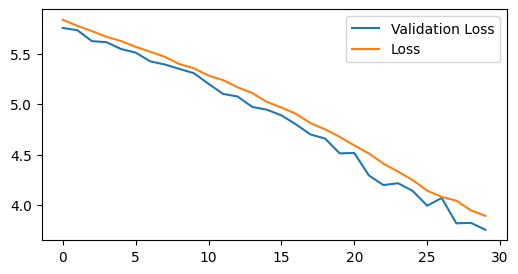

In [10]:
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

batch_size = 512
epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device), autoregressive=False) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))

        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")
    
plt.figure(figsize=(6, 3))
plt.plot(vlossi[:], label='Validation Loss')
plt.plot(lossi[:], label='Loss')
plt.legend()

In [11]:
model.reset_cache()
example = inputs[torch.zeros(1).long()]
print(example)

for i in range(1000):
    next = model.forward(example, autoregressive=True)[:, -1]
    example = torch.cat([example, next.argmax(dim=-1).unsqueeze(1)], dim=1)

print("".join(inttotext[i.item()] for i in example[0])[:20])
print("".join(inttotext[i.item()] for i in example[0])[20:])

tensor([[119, 104, 111,  32, 115, 101, 101, 107,  32,  97,  32,  99, 117, 114,
         101,  32, 102, 111, 114,  32]])
Building cache
Building cache
who seek a cure for 
<aba  a[  abe
oa d    d  aAe  it  <am d    duoni  her  ira.| iranit  hith dr  hihe   d  anis am ]the de  duon d   hoonant   d        ir he   atira   otMt d   a at  he d  dhidd ae a  am   r ra du  uouonamynihe     dduotMtheoaid d anep  dur   d  duAe ainithe dd        abeeniir  a d a   he   iniv[s ie  a  a    d am  ant  due   1 asoe  r  i whit    <athoaw  ie   am a[ honana«i d d  d duon       hintit    oonit  aùans C d   anivn dci&    ona[e  de   ir ae    se  at  a    d am d    d d         i ie   he
ve  a i d rat     d it araise    [[[  at     d   d  d   da a[[[  d d/Äf  otr inatithi d   dsott  ara   dam d dam d an    r       <ith e  d  <e d    d ]aAeonihee am aaaihee   d it   ir  ir d     dr d  dcdd  d ase d   aie itt    duooai   m  a   ran  d    a.eni   ithair  anigotir  it   dr  d   anihe at th   duote  <araA  he

In [12]:
example = inputs[torch.zeros(1).long()]
print(example)

for i in range(1000):
    next = model.forward(example, autoregressive=False)[:, -1]
    example = torch.cat([example, next.argmax(dim=-1).unsqueeze(1)], dim=1)

print("".join(inttotext[i.item()] for i in example[0])[:20])
print("".join(inttotext[i.item()] for i in example[0])[20:])

tensor([[119, 104, 111,  32, 115, 101, 101, 107,  32,  97,  32,  99, 117, 114,
         101,  32, 102, 111, 114,  32]])
who seek a cure for 
      a[         d       aiie it  at   ihe      d  her   a[   iranit  hith duot hihe      ioni at       d  d  d     hoooant   d        ir he   atir    otMt d   a  he he    dhidd ae a  am   r r  du  uouon  air d     dde  ait r id d anee  dur   d  diga ainithe  d        a e arai  a   a   he   iniv a ie  a  a    d   i ant  due   d  asoe  r  i whit    <athoa   ie   am a[ honana«i d d    dr d       hintit    oonit  aùani C d   anive dci&    ona[e  de   ir ae    se      a    d am d    d d         i ie   he  athe i d rat     d it  d  d     [    at     d   d  d   da a[[[     at a otr inatithi d   dsott  ar    dam d dam d an    r       <ith e  d  <e d    d ]aAeonihee a  aaaihee   d it   ir  ir d     dr d   a d  d ase d   aie itt    d  oaont m  a   ran  d    a.eni   ithair  anigotir  it   dr  d   a   d at th   ionte  <araA  heot   ihon  dih    dduoe  he at

In [13]:
model.reset_cache()
example = inputs[torch.zeros(1).long()]
print(example)

next1 = model.forward(example, autoregressive=False)[:, -1]
example = torch.cat([example, next1.argmax(dim=-1).unsqueeze(1)], dim=1)
next3 = model.forward(example, autoregressive=False)[:, -1]


tensor([[119, 104, 111,  32, 115, 101, 101, 107,  32,  97,  32,  99, 117, 114,
         101,  32, 102, 111, 114,  32]])


In [14]:
model.reset_cache()
example = inputs[torch.zeros(1).long()]
print(example)

next = model.forward(example, autoregressive=True)[:, -1]
example = torch.cat([example, next.argmax(dim=-1).unsqueeze(1)], dim=1)
next2 = model.forward(example, autoregressive=True)[:, -1]

tensor([[119, 104, 111,  32, 115, 101, 101, 107,  32,  97,  32,  99, 117, 114,
         101,  32, 102, 111, 114,  32]])
Building cache
Building cache


In [15]:
next1 - next

tensor([[-2.0728e-01, -7.5639e-01, -7.2591e-01, -6.1220e-01, -3.7927e-01,
         -2.6770e-01,  5.9720e-02, -4.9104e-01, -2.2266e-01, -1.5494e-01,
          8.3772e-01, -9.5382e-01, -9.9542e-01, -1.1914e+00, -7.3317e-01,
         -5.8490e-01, -2.4520e-01,  5.4854e-02, -3.8684e-01, -1.3990e+00,
         -1.0242e+00, -3.9932e-01,  4.5306e-02, -6.9686e-01, -6.0477e-01,
         -4.0259e-01, -1.5029e+00, -1.1216e-01, -1.0938e+00, -8.6229e-01,
         -5.5126e-01, -1.0707e+00,  2.2673e+00, -8.6460e-01, -1.0235e+00,
         -9.1748e-01, -1.1632e+00, -5.6449e-01, -3.7311e-01,  3.4770e-01,
          2.8508e-01, -2.5995e-01, -5.4306e-01, -9.0321e-01,  6.6420e-01,
          1.8325e-02, -1.6204e-01,  2.7986e-01, -1.3060e-01, -5.7548e-01,
          2.9152e-01, -5.5849e-01, -1.0054e+00, -2.9779e-01, -1.1769e+00,
         -3.5500e-01, -1.0958e-01,  1.5259e-02, -1.9796e-03,  7.3864e-02,
         -1.2960e+00,  5.0151e-02, -9.4187e-01, -7.9419e-01, -9.7153e-01,
          3.2750e-01, -1.2223e+00,  1.

In [16]:
next2 == next3

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F